In [1]:
import numpy as np
import pandas as pd
from random import randint
import librosa
import pickle
import matplotlib.pyplot as plt

In [2]:
digits = [ d for d in range(10) ]
names = ["george", "jackson", "lucas", "nicolas", "theo", "yweweler"]

NUM_REPEAT = 50
SILENCE_THRESHOLD = 40
AMPLIFY_FACTOR = 2

In [3]:
files_info = []
for digit in digits:
    for name in names:
        for i in range(NUM_REPEAT):
            files_info.append({"speaker": name, "digit": digit, "repeat num": i})

def return_file_path(l):
    return "./recordings/" + str(l["digit"]) + "_" + l["speaker"] + "_" + str(l["repeat num"]) + ".wav"


## Preprocess

**Trimming audio signal:** It means to remove unwanted parts from the audio file and extracting the important content in between. unwanted parts could be silent sections added at the the beginning and end of the audio. How do we detect silence? it usually is the sections with very low volume.


In [4]:
def preprocess_audio(signal, sr):
    trim_signal, _ = librosa.effects.trim(y=signal, top_db=SILENCE_THRESHOLD)
    normalized_audio = librosa.util.normalize(trim_signal)
    amplified_audio = normalized_audio * AMPLIFY_FACTOR
    return amplified_audio

### Q1. is audio segmenting helpful in our dataset?
Audio segmenting is used for more complicated datasets. Like when we have a whole paragraph and segmenting helps to find similar parts and process them together. Our dataset is very simple and each file contains only a digit. so **NO**, data segmenting isn't useful here.

## Feature Extraction
### Q2. Different types of feature extracted from an audio file:
1. **Zero-crossing rate (ZCR):** measures the number of times the audio signal crosses the zero level and change in a given time. It can be used to detect the silence parts and remove them.
2. **Mel-Frequency Cepstral Coefficients (MFCCs):** It groups the frequencies based on their similarity to the human auditory system.
3. **Mel-spectrogram:** It applies a domain filter on frequency of audio signals.
4. **chroma features:** They capture the harmonic content and musical of an audio signal. It's widely used in analyzing musical tasks. In our task we might wanna use it in recognition of speaker.

In [5]:
def extract_audio_features(audio_info):
    path = return_file_path(audio_info)
    signal, sr = librosa.load(path)

    audio = preprocess_audio(signal=signal, sr=sr)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr)
    audio_info["MFCCs"] = mfccs
    return audio_info    

## Saving data
Helps us to save time in the future steps. Also provides transfering data to other notebooks.

In [6]:
df = pd.DataFrame([extract_audio_features(file_info) for file_info in files_info])
with open('preprocessed data.pkl', 'wb') as file:
    pickle.dump(df, file)


drawing heatmap of 10 files. one for each digit (the speaker is randomly chosen)

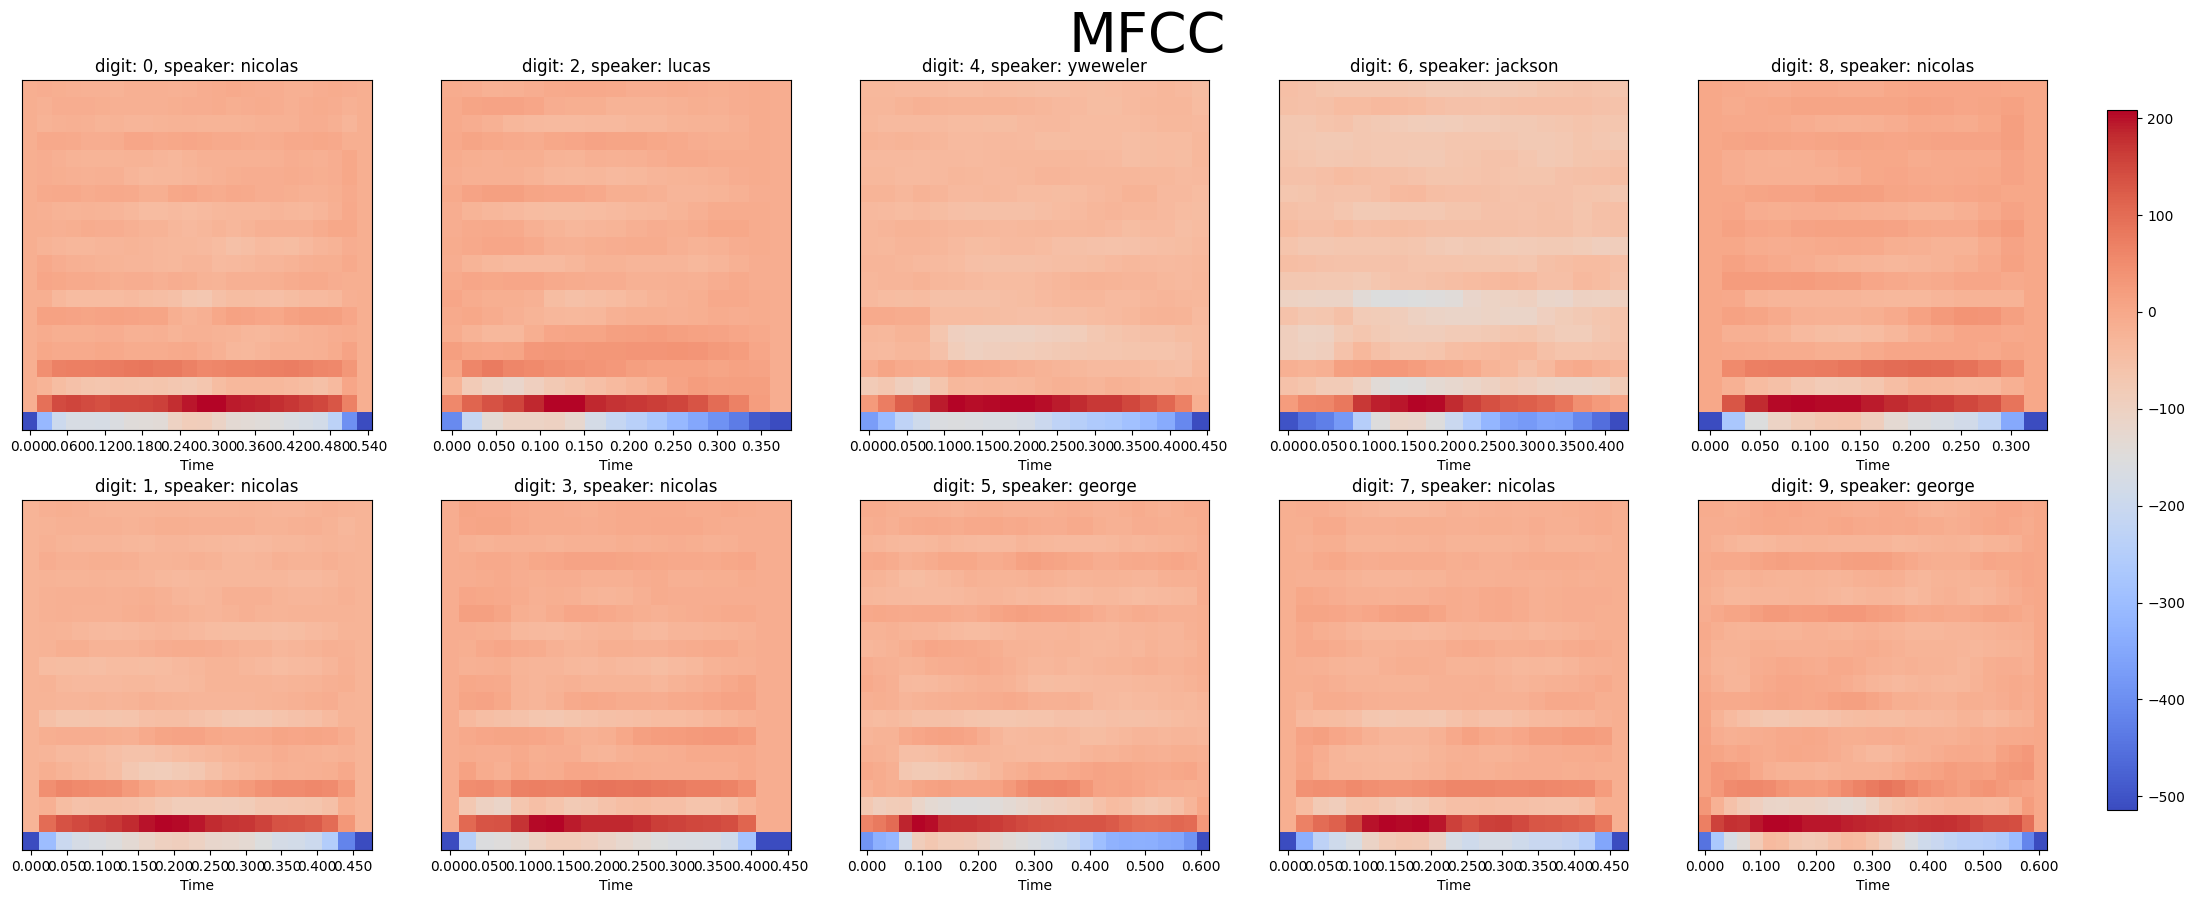

In [7]:
fig, axs = plt.subplots(2, 5, figsize=(30,10))

for i in range(10):
    data = df.iloc[300 * i + 50 * randint(0, 5)]
    img = librosa.display.specshow(data['MFCCs'], x_axis='time',ax=axs[i%2,i//2])
    axs[i%2,i//2].set_title("digit: " + str(data["digit"]) + ", speaker: " + data['speaker'])
fig.suptitle('MFCC',y=0.95,fontsize=40)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.01, 0.7])
fig.colorbar(img, cax=cbar_ax)

### Q3. robustness and sensitivity in MFCC features.
MFCCs have some limitations and can be sensitive to noise. We could reduce the noise, using noise-robust features. Robustness is the ability of processing audio algorithms to keep their performance and accuracy under a variety of conditions,  Variables like speaker, background noise and recording quality.
A robust audio processing system can handle these variations without a significant drop in performance. This is really important in real-world applications.

### Q4. Tasks that MFCCs are not much useful in:
since MFCCs are related to human auditory system, It's not very precise in fields like music and instrument recognition, environmental sounds and emotions.

### Q5. Overlap in MFCC frames.
It means that consecutive frames of audio used for calculating MFCCs partially contain the same audio content. This helps capture smooth changes in the signal and avoids losing information during processing. frames are extracted with a fixed-length of 25 ms and a fixed frame shift of 10 ms, so adjacent frames have overlapping content, usually around 75%.

### Q6. reason of only using first 13 MFCCs
because they capture most of the important information (around 80-95% of the total energy) while keeping computation efficient. rest of the coefficients may add unnecessary data and increase complexity.